In [ ]:
import re
import pandas as pd
import numpy as np
import ast
import math
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# from sklearn.metrics import f1_score, hamming_loss, accuracy_score
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import (
    f1_score, precision_recall_curve, classification_report, average_precision_score
)
from sklearn.metrics import precision_recall_curve, average_precision_score

# Data Pre-processing

In [2]:
data_overview = pd.read_csv('./Data/movies_overview.csv')
data_tags = pd.read_csv('./Data/movies_genres.csv')
data_overview.head()

,title,overview,genre_ids
0,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,"[18, 80]"
1,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...","[18, 80]"
2,The Godfather Part II,In the continuing saga of the Corleone crime f...,"[18, 80]"
3,Schindler's List,The true story of how businessman Oskar Schind...,"[18, 36, 10752]"
4,12 Angry Men,The defense and the prosecution have rested an...,[18]


In [3]:
data_tags.head()
tag_map = dict(zip(data_tags['id'], data_tags['name']))
print(tag_map)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [4]:
if isinstance(data_overview['genre_ids'].iloc[0], str):
    data_overview['genre_ids'] = data_overview['genre_ids'].apply(ast.literal_eval)

In [5]:
def ids_to_names(tag_id_str):
    return [tag_map.get(tag_id, "UNKNOWN") for tag_id in tag_id_str]
    

In [6]:
data_overview['tag_names'] = data_overview['genre_ids'].apply(ids_to_names)

In [7]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [8]:
data_overview['overview'] = data_overview['overview'].apply(clean_text)
data_overview['title'] = data_overview['title'].apply(clean_text)   

In [22]:
data_overview.head()

,title,overview,genre_ids,tag_names
0,the shawshank redemption,imprisoned in the 1940s for the double murder ...,"[18, 80]","[Drama, Crime]"
1,the godfather,"spanning the years 1945 to 1955, a chronicle o...","[18, 80]","[Drama, Crime]"
2,the godfather part ii,in the continuing saga of the corleone crime f...,"[18, 80]","[Drama, Crime]"
3,schindler's list,the true story of how businessman oskar schind...,"[18, 36, 10752]","[Drama, History, War]"
4,12 angry men,the defense and the prosecution have rested an...,[18],[Drama]


In [9]:
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(data_overview['tag_names']), columns=mlb.classes_)

# EDA

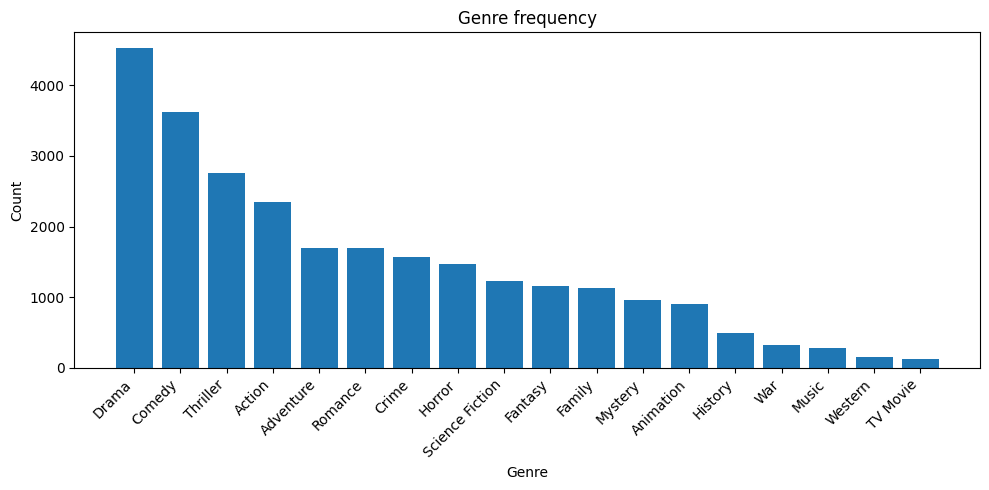

In [ ]:


# Label distribution
def plot_genre_frequency(df, label_col='tag_names', top_n=None):
    """Bar chart of genre frequencies; top_n keeps the plot readable."""
    freq = Counter(g for lst in df[label_col] for g in lst)
    items = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    if top_n is not None:
        items = items[:top_n]
    labels, counts = zip(*items) if items else ([], [])
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(labels)), counts)
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    plt.title("Genre frequency")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_genre_frequency(data_overview, label_col='tag_names')

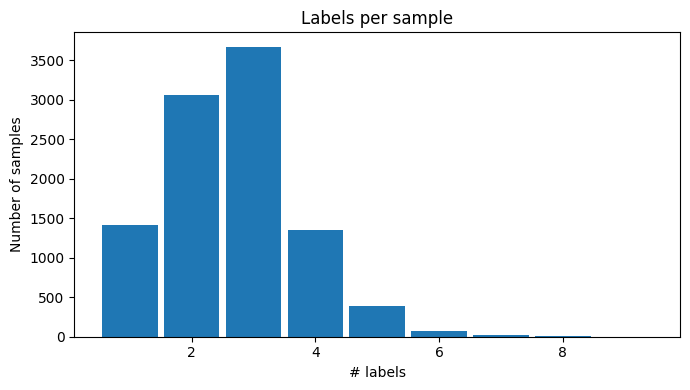

In [30]:
def plot_labels_per_sample_hist(df, label_col='tag_names'):
    """Histogram of how many labels each sample has."""
    counts = [len(t) for t in df[label_col]]
    plt.figure(figsize=(7, 4))
    plt.hist(counts, bins=range(1, max(counts)+2 if counts else 2), align='left', rwidth=0.9)
    plt.title("Labels per sample")
    plt.xlabel("# labels")
    plt.ylabel("Number of samples")
    plt.tight_layout()
    plt.show()
plot_labels_per_sample_hist(data_overview, label_col='tag_names')

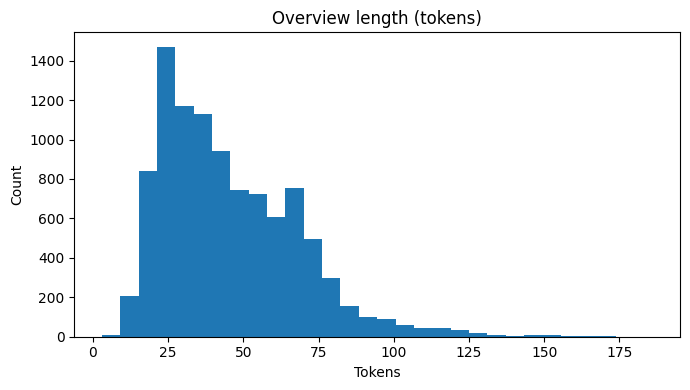

In [31]:
def plot_overview_length_hist(df, text_col='overview'):
    """Histogram of overview lengths (in tokens)."""
    lens = df[text_col].fillna("").astype(str).map(lambda s: len(s.split()))
    plt.figure(figsize=(7, 4))
    plt.hist(lens, bins=30)
    plt.title("Overview length (tokens)")
    plt.xlabel("Tokens")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
plot_overview_length_hist(data_overview, text_col='overview')

In [34]:
# Count tokens by splitting on whitespace
mask = data_overview['overview'].map(lambda s: len(s.split()) < 8)

# Filter
short_overviews = data_overview.loc[mask, ['title', 'overview', 'tag_names']]

print(short_overviews)

                         title  \
341           tel chi el telùn   
3569                    return   
4712                      bros   
8446  grande, grosso e verdone   

                                               overview          tag_names  
341                                      a comedy show.           [Comedy]  
3569            8mm work directed by norihiko morinaga.            [Drama]  
4712  two emotionally unavailable men attempt a rela...  [Comedy, Romance]  
8446           a comic movie divided in three episodes.           [Comedy]  


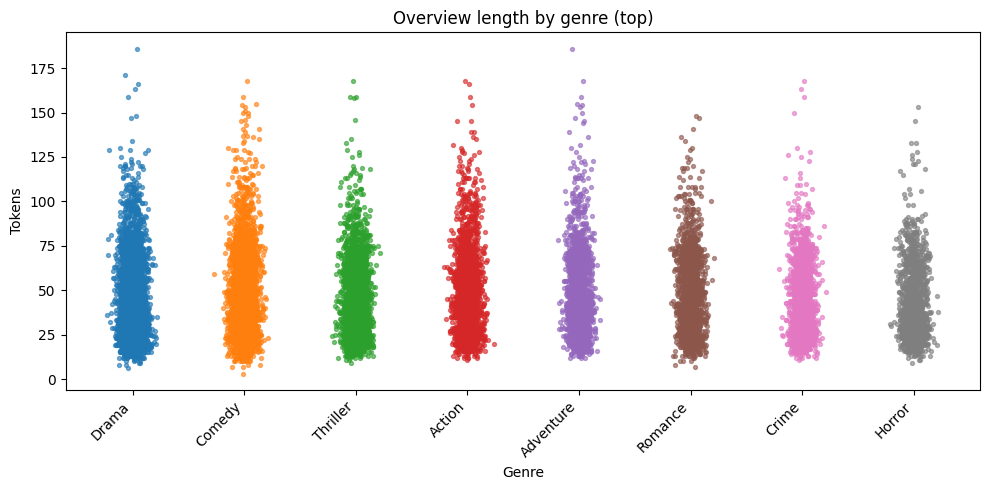

In [36]:
def plot_overview_length_by_label(df, label_col='tag_names', text_col='overview', top_n=8):
    """Box-like strip plot using matplotlib scatter per top-N labels by frequency."""
    lens = df[text_col].fillna("").astype(str).map(lambda s: len(s.split())).to_numpy()
    freq = Counter(g for lst in df[label_col] for g in lst)
    top = [g for g, _ in freq.most_common(top_n)]
    data = {g: [] for g in top}
    for i, lst in enumerate(df[label_col]):
        for g in lst:
            if g in data:
                data[g].append(lens[i])

    labels = list(data.keys())
    plt.figure(figsize=(10, 5))
    for i, g in enumerate(labels):
        y = data[g]
        if len(y) == 0: 
            continue
        x = np.random.normal(i+1, 0.06, size=len(y))
        plt.scatter(x, y, s=8, alpha=0.6)
    plt.xticks(range(1, len(labels)+1), labels, rotation=45, ha='right')
    plt.title("Overview length by genre (top)")
    plt.xlabel("Genre")
    plt.ylabel("Tokens")
    plt.tight_layout()
    plt.show()
plot_overview_length_by_label(data_overview, label_col='tag_names', text_col='overview')

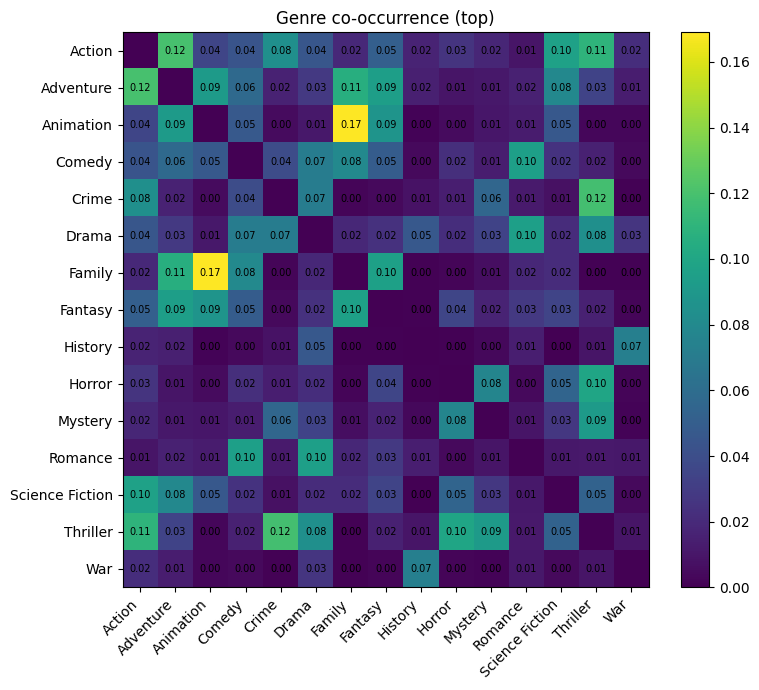

In [43]:
def compute_cooccurrence(Y,mlb):
    """Return (C, genres) where C is co-occurrence matrix.
    y- Binarized tag names, mlb - Multi label binarizer"""
    C = Y.T @ Y  # counts of co-occurrence
    np.fill_diagonal(C, 0)
    return C, mlb.classes_

def plot_cooccurrence_heatmap(df, mlb,label_col='tag_names', top_n=15):
    """Heatmap of co-occurrence for top-N frequent genres."""
    freq = Counter(g for lst in df[label_col] for g in lst)
    top = set(g for g, _ in freq.most_common(top_n))
    # filter rows to only those having at least one top label to emphasize signal
    filtered = [list(set(lst) & top) for lst in df[label_col]]
    Y = mlb.fit_transform(filtered)
    if Y.shape[1] == 0:
        print("No labels to plot. Increase top_n.")
        return
    C = Y.T @ Y
    #juccard
    size = np.diag(C + np.diag(Y.sum(axis=0)))
    union = size[:, None] + size[None, :] - C
    M = np.divide(C, union, where=union > 0)
    #corr
    # size = Y.sum(axis=0)
    # denom = np.sqrt(np.outer(size, size))
    # M = np.divide(C, denom, where=denom > 0)
    
    np.fill_diagonal(M, 0)
    plt.figure(figsize=(8, 7))
    plt.imshow(M, aspect='auto')
    plt.xticks(range(len(mlb.classes_)), mlb.classes_, rotation=45, ha='right')
    plt.yticks(range(len(mlb.classes_)), mlb.classes_)
    plt.title("Genre co-occurrence (top)")
    plt.colorbar()
    # Annotate each cell with value
    genres = mlb.classes_
    
    for i in range(len(genres)):
        for j in range(len(genres)):
            if i == j: continue
            val = M[i, j]
            txt = f"{val:.2f}"
            plt.text(j, i, txt, ha="center", va="center", color="black", fontsize=7)

    plt.tight_layout()
    plt.show()
    
plot_cooccurrence_heatmap(data_overview, mlb,label_col='tag_names', top_n=15)

## Feature Engineering

In [10]:
#creating features varients
#overview only
x = data_overview['overview']
#title and overview
xt = (data_overview['title'] + ' ').str.strip() + ' ' + data_overview['overview']

In [ ]:
results = []

def upsample_multilabel(X, Y, target='median', random_state=42):
    """Upsample rows in X/Y (multi-label) so minority labels reach the target count."""
    # X: pd.Series or pd.DataFrame (rows of text), Y: pd.DataFrame (one-hot labels)
    counts = Y.sum()
    if target == 'median':
        tgt = int(counts.median())
    elif target == 'max':
        tgt = int(counts.max())
    else:
        tgt = int(target)
    # nothing to do
    if tgt <= counts.min():
        return X.reset_index(drop=True), Y.reset_index(drop=True)
    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)
    rows_to_add = []
    rng = np.random.RandomState(random_state)
    for label in Y.columns:
        c = counts[label]
        if c == 0 or c >= tgt:
            continue
        needed = tgt - int(c)
        idxs = Y[Y[label] == 1].index.tolist()
        if not idxs:
            continue
        sampled = rng.choice(idxs, size=needed, replace=True)
        rows_to_add.extend(sampled.tolist())
    if not rows_to_add:
        return X, Y
    X_add = X.iloc[rows_to_add].reset_index(drop=True)
    Y_add = Y.iloc[rows_to_add].reset_index(drop=True)
    X_new = pd.concat([X, X_add], ignore_index=True)
    Y_new = pd.concat([Y, Y_add], ignore_index=True)
    # shuffle
    perm = rng.permutation(len(X_new))
    X_new = X_new.iloc[perm].reset_index(drop=True)
    Y_new = Y_new.iloc[perm].reset_index(drop=True)
    return X_new, Y_new

# def train_model(x, y, data_name):
    
#     x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#     x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

#     # Upsample minority labels in the training set to median label count
#     x_train, y_train = upsample_multilabel(x_train, y_train, target='median', random_state=42)
#     print('After upsampling train label counts:\n', y_train.sum().sort_values(ascending=False))

#     pipe = Pipeline([
#         ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')),
#         ('clf', OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, class_weight='balanced')))
#     ])
    
#     print(f"Train set size: {len(x_train)}")
#     print(f"Validation set size: {len(x_val)}")
#     print(f"Test set size: {len(x_test)}")  
#     print(f"Number of classes: {len(y.columns)}")


#     pipe.fit(x_train, y_train)

#     y_valid_pred = pipe.predict(x_val)
#     y_test_pred = pipe.predict(x_test)

#     val_micro_f1 = f1_score(y_val, y_valid_pred, average='micro')
#     val_macro_f1 = f1_score(y_val, y_valid_pred, average='macro')
#     val_hamming_loss = hamming_loss(y_val, y_valid_pred)
#     val_accuracy = accuracy_score(y_val, y_valid_pred)

#     print(f"Validation Micro F1: {val_micro_f1}")
#     print(f"Validation Macro F1: {val_macro_f1}")
#     print(f"Validation Hamming Loss: {val_hamming_loss}")
#     print(f"Validation Accuracy: {val_accuracy}")

#     test_micro_f1 = f1_score(y_test, y_test_pred, average='micro')
#     test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
#     test_hamming_loss = hamming_loss(y_test, y_test_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     print(f"Test Micro F1: {test_micro_f1}")
#     print(f"Test Macro F1: {test_macro_f1}")
#     print(f"Test Hamming Loss: {test_hamming_loss}")
#     print(f"Test Accuracy: {test_accuracy}")
    
#     results.append({
#         'data': data_name,
#         'val_micro_f1': val_micro_f1,
#         'val_macro_f1': val_macro_f1,
#         'val_hamming_loss': val_hamming_loss,
#         'test_micro_f1': test_micro_f1,
#         'test_macro_f1': test_macro_f1,
#         'test_hamming_loss': test_hamming_loss
#     })
    
#     print(type(y_test_pred),y_test_pred)
#     return pipe, (x_train, y_train, x_val, y_val, x_test, y_test)
    

# Train

In [48]:
def train_model(x, y, data_name):
    
    x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

    # Upsample minority labels in the training set to median label count
    x_train, y_train = upsample_multilabel(x_train, y_train, target='median', random_state=42) #TODO: move to preproccesing
    print('After upsampling train label counts:\n', y_train.sum().sort_values(ascending=False))

    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')),
        ('clf', OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1, class_weight='balanced')))
    ])
    
    print(f"Train set size: {len(x_train)}")
    print(f"Validation set size: {len(x_val)}")
    print(f"Test set size: {len(x_test)}")  
    print(f"Number of classes: {len(y.columns)}")


    pipe.fit(x_train, y_train)

    # Get probabilities
    proba = pipe.predict_proba(x_val)   # shape: [n_samples, n_labels]

    # Option A: fixed threshold (e.g., 0.4)
    thr = 0.4
    Y_pred_thr = (proba >= thr).astype(int)

    # Option B: top-k (e.g., always pick top 2)
    k = 2
    Y_pred_topk = np.zeros_like(proba, dtype=int)
    topk_idx = np.argsort(-proba, axis=1)[:, :k]
    rows = np.arange(proba.shape[0])[:, None]
    Y_pred_topk[rows, topk_idx] = 1

    # Evaluate
    print("F1 micro (thr=0.4):", f1_score(y_val, Y_pred_thr, average="micro"))
    print("F1 micro (top-2):", f1_score(y_val, Y_pred_topk, average="micro"))
    return {"pipe":pipe,"x_train":x_train, "y_train":y_train, "x_val":x_val, "y_val":y_val, "x_test":x_test, "y_test":y_test}
   

In [49]:
# pipe_overview, data_overview_split = train_model(x, y, 'overview')
train_result = train_model(xt, y, 'title + overview')

After upsampling train label counts:
 Drama              4722
Comedy             3323
Action             2203
Thriller           2147
Adventure          1772
Romance            1587
Family             1315
Crime              1203
Fantasy            1158
Horror             1107
Science Fiction    1093
Animation          1089
History            1047
Music               896
War                 879
Mystery             862
TV Movie            808
Western             776
dtype: int64
Train set size: 9704
Validation set size: 1597
Test set size: 1996
Number of classes: 18


c:\Users\Thej\MyProjectsTesings\interview\.pyenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 micro (thr=0.4): 0.5968206749093613
F1 micro (top-2): 0.540692989524577


## evaluation utils

In [57]:
def classification_report_df(y_true, y_pred, class_names=None):
    """classification_report as a tidy DataFrame."""
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    df = pd.DataFrame(report).T
    return df

def plot_per_label_f1(y_true, y_pred, class_names):
    """Bar chart of per-label F1."""
    f1s = []
    for j in range(y_true.shape[1]):
        f1s.append(f1_score(y_true[:, j], y_pred[:, j], zero_division=0))
    idx = np.argsort(f1s)[::-1]
    labels = [class_names[i] for i in idx]
    vals = [f1s[i] for i in idx]
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(vals)), vals)
    plt.xticks(range(len(vals)), labels, rotation=45, ha='right')
    plt.title("Per-label F1")
    plt.xlabel("Label")
    plt.ylabel("F1")
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curves(y_true, scores, class_names=None, max_labels=6):
    """
    Precision–Recall curves for up to max_labels labels.
    Works whether y_true/scores are pandas, numpy, or scipy sparse.
    """
    # ---- normalize inputs to dense numpy arrays ----
    try:
        import scipy.sparse as sp
        if sp.issparse(y_true):
            y_true = y_true.toarray()
        if sp.issparse(scores):
            scores = scores.toarray()
    except Exception:
        pass

    # pandas -> numpy
    if hasattr(y_true, "to_numpy"):
        y_true = y_true.to_numpy()
    else:
        y_true = np.asarray(y_true)

    if hasattr(scores, "to_numpy"):
        scores = scores.to_numpy()
    else:
        scores = np.asarray(scores)

    assert y_true.ndim == 2 and scores.ndim == 2, "y_true and scores must be 2D"
    assert y_true.shape == scores.shape, f"Shape mismatch: {y_true.shape} vs {scores.shape}"

    n_labels = y_true.shape[1]
    k = min(max_labels, n_labels)

    # default class names
    if class_names is None:
        class_names = [f"label_{j}" for j in range(n_labels)]
    else:
        assert len(class_names) == n_labels, "class_names length must match #labels"

    # ---- plot each label separately (one figure per label) ----
    import matplotlib.pyplot as plt
    for j in range(k):
        yj_true = y_true[:, j].ravel()
        yj_score = scores[:, j].ravel()
        p, r, _ = precision_recall_curve(yj_true, yj_score)
        ap = average_precision_score(yj_true, yj_score)

        plt.figure(figsize=(5, 4))
        plt.plot(r, p)
        plt.title(f"PR: {class_names[j]} (AP={ap:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.tight_layout()
        plt.show()
        
def topk_predict(scores, k):
    """Binary predictions selecting top-k labels per sample from scores."""
    n, m = scores.shape
    y_pred = np.zeros((n, m), dtype=int)
    if m == 0:
        return y_pred
    k = max(1, min(k, m))
    idx = np.argpartition(-scores, kth=k-1, axis=1)[:, :k]
    rows = np.arange(n)[:, None]
    y_pred[rows, idx] = 1
    return y_pred

def evaluate_threshold_and_topk(pipe, X_val, y_val, X_test, y_test, class_names=None, ks=(1,2,3,4,5)):
    """
    Evaluate threshold=0.5 and top-k (pick best k on val by micro-F1).
    Returns a dictionary of metrics and prints concise results.
    """
    # Hard predictions at 0.5
    yv_pred_thr = pipe.predict(X_val)
    yt_pred_thr = pipe.predict(X_test)

    def _metrics(y_true, y_pred):
        return {
            "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0),
            "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
            "hamming":  hamming_score(y_true, y_pred),  # see helper below
            "subset_acc": (y_true == y_pred).all(axis=1).mean(),
        }

    # Soft scores (probabilities if available, else decision_function)
    if hasattr(pipe, "predict_proba"):
        scores_val = pipe.predict_proba(X_val)
        scores_test = pipe.predict_proba(X_test)
    else:
        # Pipeline often exposes via the final step:
        clf = pipe.named_steps.get('clf', pipe)
        if hasattr(clf, "predict_proba"):
            scores_val = clf.predict_proba(X_val)
            scores_test = clf.predict_proba(X_test)
        elif hasattr(clf, "decision_function"):
            scores_val = clf.decision_function(X_val)
            scores_test = clf.decision_function(X_test)
        else:
            # Fallback to hard preds as scores (not ideal)
            scores_val = yv_pred_thr.astype(float)
            scores_test = yt_pred_thr.astype(float)

    # Top-k search on validation
    best_k, best_val = None, -1.0
    by_k = {}
    for k in ks:
        yv_pred_k = topk_predict(scores_val, k)
        m = _metrics(y_val, yv_pred_k)
        by_k[k] = m
        if m["micro_f1"] > best_val:
            best_val = m["micro_f1"]
            best_k = k

    # Test with best_k
    yt_pred_k = topk_predict(scores_test, best_k)
    val_thr = _metrics(y_val, yv_pred_thr)
    test_thr = _metrics(y_test, yt_pred_thr)
    test_k  = _metrics(y_test, yt_pred_k)

    # Quick printout
    print("Validation @0.5:", val_thr)
    print("Top-k candidates (val):")
    for k in ks:
        print(f"  k={k} -> {by_k[k]}")
    print(f"Selected best_k={best_k}")
    print("Test @0.5:", test_thr)
    print(f"Test @top-{best_k}:", test_k)

    return {
        "val_threshold": val_thr,
        "val_topk_by_k": by_k,
        "best_k": best_k,
        "test_threshold": test_thr,
        "test_topk": test_k,
    }

def hamming_score(y_true, y_pred):
    """
    Hamming score (a.k.a. label-based accuracy): average Jaccard-like per-sample agreement.
    Equivalent to 1 - Hamming loss when averaged differently; included for convenience.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    num = (y_true == y_pred).sum(axis=1)
    den = y_true.shape[1]
    return (num / den).mean()

## evaluations

In [50]:
results = evaluate_threshold_and_topk(train_result["pipe"], 
                                      train_result["x_val"], 
                                      train_result["y_val"], 
                                      train_result["x_test"], 
                                      train_result["y_test"], 
                                      class_names=mlb.classes_, ks=(1,2,3,4,5))


Validation @0.5: {'micro_f1': 0.6043148955703466, 'macro_f1': 0.5145762410453286, 'hamming': np.float64(0.8800528769220067), 'subset_acc': np.float64(0.10707576706324358)}
Top-k candidates (val):
  k=1 -> {'micro_f1': 0.39904257137972304, 'macro_f1': 0.3029867364088242, 'hamming': np.float64(0.8777221178598763), 'subset_acc': np.float64(0.08265497808390733)}
  k=2 -> {'micro_f1': 0.540692989524577, 'macro_f1': 0.43251750883740775, 'hamming': np.float64(0.8810269254852849), 'subset_acc': np.float64(0.08891671884783969)}
  k=3 -> {'micro_f1': 0.5909543293154926, 'macro_f1': 0.4963548320378463, 'hamming': np.float64(0.8713212273011898), 'subset_acc': np.float64(0.07701941139636818)}
  k=4 -> {'micro_f1': 0.5845864661654135, 'macro_f1': 0.5041923752614648, 'hamming': np.float64(0.8462394767967718), 'subset_acc': np.float64(0.022542266750156543)}
  k=5 -> {'micro_f1': 0.5568358257742911, 'macro_f1': 0.4854047244837428, 'hamming': np.float64(0.811347665762193), 'subset_acc': np.float64(0.004

In [53]:
# # Per-label F1 bar chart:
pipe=train_result["pipe"]
# y_test_pred = pipe.predict(train_result["x_test"])           
# plot_per_label_f1(train_result["y_test"], y_test_pred, class_names=mlb.classes_)


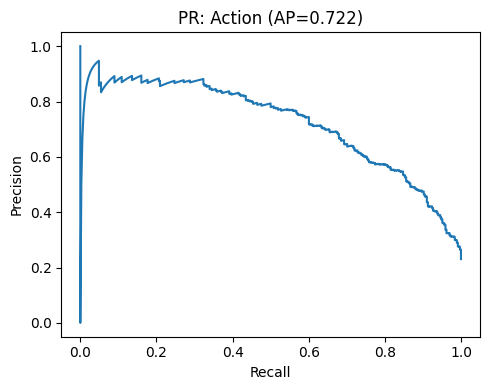

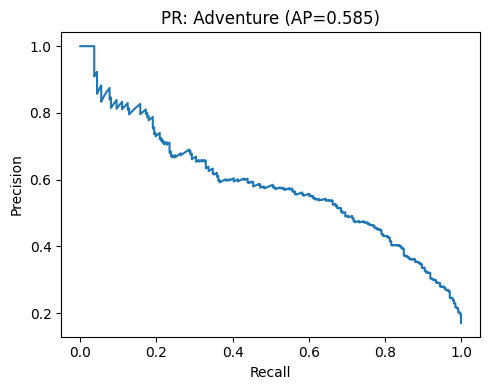

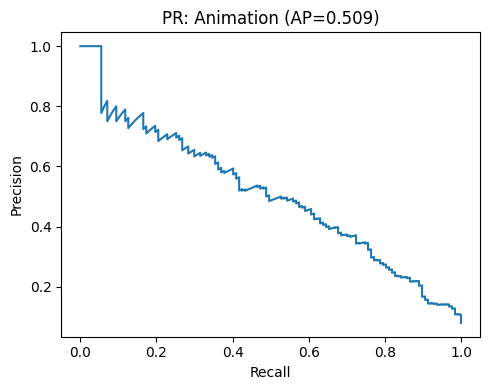

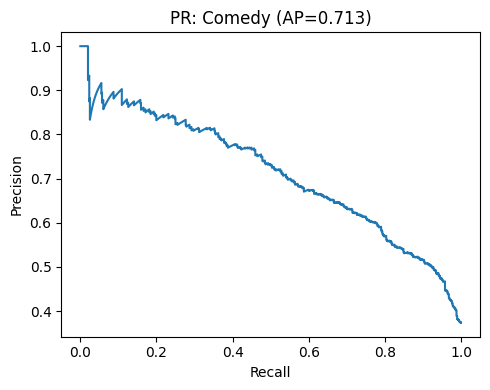

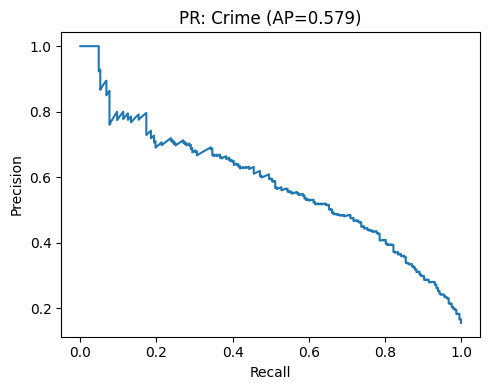

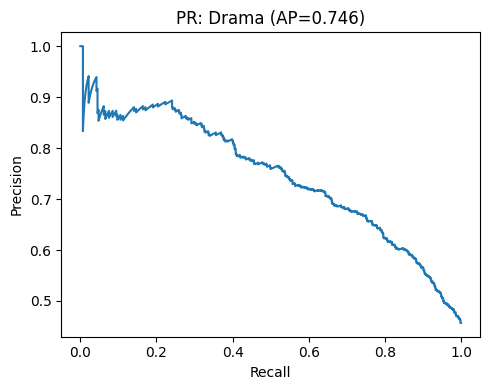

In [59]:
# Precision-Recall curves for a few labels:
scores_val = pipe.predict_proba(train_result["x_val"])        # or decision_function
plot_precision_recall_curves(train_result["y_val"], scores_val, class_names=getattr(train_result["y_val"], "columns", None), max_labels=6)

In [13]:
def review_results(results, pipe_overview, pipe_title_overview, data_overview_split, data_title_overview_split):
    res = pd.DataFrame(results)
    
    #best pipeline (choose by val_micro_f1)
    best_idx = res['val_micro_f1'].idxmax()
    best_res = res.loc[best_idx, 'data']
    print('Best data by val_micro_f1:', best_res)
    if best_res == 'overview_only':
        chosen_pipe = pipe_overview
        chosen_split = data_overview_split
    else:
        chosen_pipe = pipe_title_overview
        chosen_split = data_title_overview_split

    
    # Dataset imbalance check (label frequencies)
    label_counts = y.sum().sort_values(ascending=False)
    print('\nTop label frequencies:\n', label_counts.head(10))
    print('\nBottom label frequencies:\n', label_counts.tail(10))
        
    # Verify every label appears in train and test for the chosen splits
    X_val, X_test, _, y_val, _, y_test = chosen_split
    missing_in_val = [c for c in y.columns if y_val[c].sum() == 0]
    missing_in_test = [c for c in y.columns if y_test[c].sum() == 0]
    print('Missing labels in val:', missing_in_val)
    print('Missing labels in test:', missing_in_test)
    
    #reports 
    res.to_csv('./results.csv', index=False)
    pd.DataFrame([{
        'n_samples': len(data_overview),
        'n_labels': len(mlb.classes_)
    }]).to_csv('./report.txt', index=False)


    label_counts.to_csv('./label_counts.csv')
    
    joblib.dump(chosen_pipe, './best_model.pkl')
    
    label_counts.plot(kind='bar', figsize=(10,5), title='Label Frequencies')
    plt.show()
    
    


Best data by val_micro_f1: title + overview

Top label frequencies:
 Drama              4523
Comedy             3626
Thriller           2757
Action             2349
Adventure          1700
Romance            1699
Crime              1573
Horror             1475
Science Fiction    1235
Fantasy            1154
dtype: int64

Bottom label frequencies:
 Science Fiction    1235
Fantasy            1154
Family             1134
Mystery             966
Animation           910
History             490
War                 324
Music               279
Western             152
TV Movie            119
dtype: int64
Missing labels in val: []
Missing labels in test: []


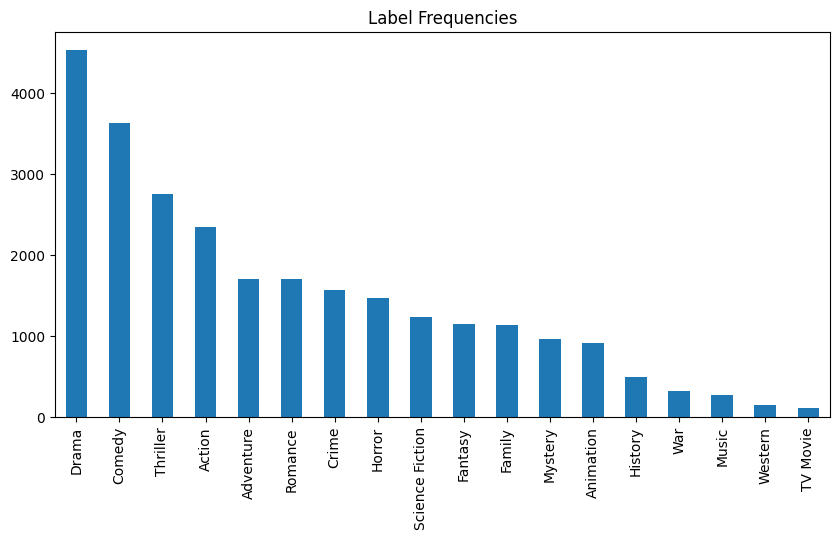

In [ ]:
#
# review_results(results, pipe_overview, pipe_title_overview, data_overview_split, data_title_overview_split)

In [60]:

# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.ensemble import RandomForestClassifier

# cls = MultiOutputClassifier(RandomForestClassifier())
# cls.fit(x_train, y_train)
# 

In [80]:
'''
y_valid_pred = cls.predict(x_val)
y_valid_pred_f = pd.DataFrame(y_valid_pred, columns=y.columns)
'''

'\ny_valid_pred = cls.predict(x_val)\ny_valid_pred_f = pd.DataFrame(y_valid_pred, columns=y.columns)\n'

In [81]:
'''
from sklearn.metrics import classification_report

print("📊 Validation Results:")
for col in y.columns:
    print(f"\n--- {col} ---")
    print(classification_report(y_val[col], y_valid_pred_f[col]))
    '''

'\nfrom sklearn.metrics import classification_report\n\nprint("📊 Validation Results:")\nfor col in y.columns:\n    print(f"\n--- {col} ---")\n    print(classification_report(y_val[col], y_valid_pred_f[col]))\n    '

In [82]:
'''
y_test_pred = cls.predict(x_test)
print("📊 Test Results:")
for col in y.columns:
    print(f"\n--- {col} ---")
    print(classification_report(y_test[col], y_test_pred[:, y.columns.get_loc(col)]))
'''

'\ny_test_pred = cls.predict(x_test)\nprint("📊 Test Results:")\nfor col in y.columns:\n    print(f"\n--- {col} ---")\n    print(classification_report(y_test[col], y_test_pred[:, y.columns.get_loc(col)]))\n'

In [83]:
'''
from sklearn.metrics import accuracy_score

# Label-wise exact match
print("Exact Match Accuracy (Validation):", accuracy_score(y_val, y_valid_pred))
'''

'\nfrom sklearn.metrics import accuracy_score\n\n# Label-wise exact match\nprint("Exact Match Accuracy (Validation):", accuracy_score(y_val, y_valid_pred))\n'

In [84]:
'''

joblib.dump(cls, "multi_label_model.pkl")
#Would Comments on what to do next
'''


'\n\njoblib.dump(cls, "multi_label_model.pkl")\n#Would Comments on what to do next\n'